In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import random
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Datasets/train.tsv', sep = '\t')
test = pd.read_csv('/content/drive/MyDrive/Datasets/test.tsv', sep = '\t')

def data(n, seed):

    datas = []
    
    random.seed(seed)
    for i in range(n):
        dia_maximo = 30
        dia_minimo = 1
        mes_maximo = 12
        mes_minimo = 1
        
        dia = int(round(random.random() * (dia_maximo - dia_minimo) + dia_minimo, 0))
        mes = int(round(random.random() * (mes_maximo - mes_minimo) + mes_minimo, 0))
        
        datas.append(str(dia)+'-'+str(mes)+'-2018')
        
    return datas

def estoque(n, seed):

    np.random.seed(seed)
    mu, sigma = 1, 20
    s = np.random.normal(mu, sigma, n)
    s[s < 0] = s[s < 0] * -0.5
    s = s.astype(int)
    s[s < 1] = 1
    
    return s

train['date']  = data(n = train.shape[0], seed = 10)
train['stock'] = estoque(n = train.shape[0], seed = 10)

test['date']  = data(n = test.shape[0], seed = 15)
test['stock'] = estoque(n = test.shape[0], seed = 15)

train.drop('train_id', axis=1, inplace=True)
train['item_condition_id'] = train['item_condition_id'].astype('str')

A função de geração das datas gera um número aleatório de 0 até 1 multiplicado pela faixa de dias possíveis mais o dia minimo. A função original arredondava o resultado para inteiro através da utilização do método int(), este método simplesmente elimina a parte decimal de um número tornando os valores extremos (1, 12 e 30) extremamente raros. A utilização da função round() permite que os valores sejam distribuídos inclusive para os extremos.

In [4]:
train.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,date,stock
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,18-6-2018,27
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,18-3-2018,15
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,25-10-2018,14
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,20-3-2018,1
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,16-5-2018,13


# EDA

Aqui tentaremos ter uma ideia geral sobre o negócio, como por exemplo:

* Qual a distribuição de preços?
* Quais são as categorias mais frequentes no conjunto de dados?
* Existe alguma relação entre categoria e preço?
* Qual a distribuição do preço?
* Como os meses afetam as vendas?

## Análise da variável 'price'

Uma das primeiras analises que precisam ser feitas é em relação a variável 'price', essa é variável que será sugerida para nossos clientes.

In [5]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

Notamos que o valor minímo das vendas é de US\$ 0, esse valor sugere que produtos são doados através do serviço de ecommerce e não são uteis para nosso modelo preditivo. Tambem notamos uma mediana de US\$ 17 e uma média de US$ 26,7 indicando uma dispersão assimétrica dos valores.

Há uma grande amplitude entre os valores de média e mediana e o valor máximo do dataset, esse tipo de comportamento pode gerar problemas na visualização dos valores e pode ser corrigido com a aplicação de uma transformação logaritmica na variável.

A função log1p do numpy realiza essa transformação (adicionando 1 a variável envolvida para evitar valores negativos e o 0).

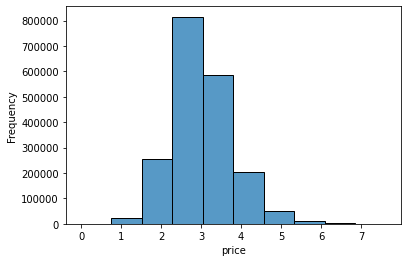

In [6]:
sns.histplot(train['price'].apply(lambda x: np.log1p(x)), stat='frequency', bins=10)

Vemos que a distribuição do preço transformado tende a seguir uma distribuição normal, sendo muito mais adequado para a aplicação em um modelo de machine learning.

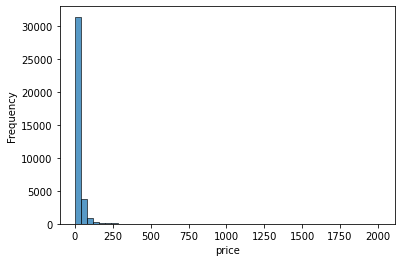

In [7]:
sns.histplot(x=train['price'], stat='frequency', bins=50)

Este histograma ilustra o problema, há uma grande amplitude entre os valores minimos e máximos além dos valores serem distribuidos de forma assimétrica. Como a grande maioria dos valores está concentrado na faixa entre \$0 e \$250, a análise a seguir se concentrará nesta faixa.

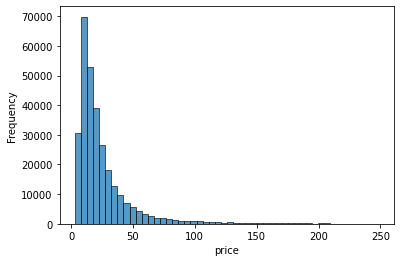

In [8]:
sns.histplot(x=train[(train['price'] > 0) & (train['price'] < 250)]['price'], stat='frequency', bins=50)

Mesmo faixa de valores entre \$0 e \$250 ainda notamos uma forte distribuição assimétrica, porém, a visualização dos dados começa a ficar mais clara, deixando mais explicito o perfil de vendas das pessoas que utilizam este tipo de serviço.

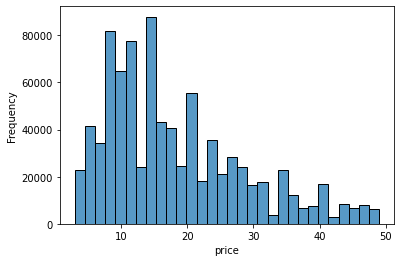

In [9]:
sns.histplot(x=train[(train['price'] > 0) & (train['price'] < 50)]['price'], stat='frequency', bins=30)

In [18]:
print('Total de observações: ', train['price'].count())
print('Total de observações com preço até $250: ', train[(train['price'] > 0) & (train['price'] < 250)]['price'].count())
print('Total de observações com preço até $50:', train[(train['price'] > 0) & (train['price'] < 50)]['price'].count())
print('')
print('% de observações com preço até $250: ', round(train[(train['price'] > 0) & (train['price'] < 250)]['price'].count()/train['price'].count()*100, 2),'%')
print('% de observações com preço até $50:', round(train[(train['price'] > 0) & (train['price'] < 50)]['price'].count()/train['price'].count()*100, 2),'%')
print('')
print('Faturamento com preço total: $', round(train['price'].sum()*0.1, 2))
print('Faturamento com preço até $250: $', round(train[(train['price'] > 0) & (train['price'] < 250)]['price'].sum()*0.1, 2))
print('Faturamento com preço até $50: $', round(train[(train['price'] > 0) & (train['price'] < 50)]['price'].sum()*0.1, 2))

Total de observações:  1482535
Total de observações com preço até $250:  1475215
Total de observações com preço até $50: 1322308

% de observações com preço até $250:  99.51 %
% de observações com preço até $50: 89.19 %

Faturamento com preço total: $ 3963930.35
Faturamento com preço até $250: $ 3705188.1
Faturamento com preço até $50: $ 2404562.15


Visto a diferença mínima no nº de observações nas faixas de preço estudadas, outra possibilidade é a utilização de um modelo descartando todos os valores acima de \$250 ou \$50, este tipo de abordagem nos permite focar na faixa onde temos maior volume de usuários, minimizando o erro especificamente neste público.

In [ ]:
# Função inicial de tratamento das categorias e separação em colunas diferentes.

rotulos = [i for i in train['category_name'].fillna('missing/missing/missing').str.split("/")]

gen_cat = []
sub1_cat = []
sub2_cat = []

for i in range(0,len(rotulos)):
  gen_cat.append(rotulos[i][0])
  sub1_cat.append(rotulos[i][1])
  sub2_cat.append(rotulos[i][2])

train['gen_cat'] = gen_cat
train['sub1_cat'] = sub1_cat
train['sub2_cat'] = sub2_cat

del gen_cat
del sub1_cat
del sub2_cat

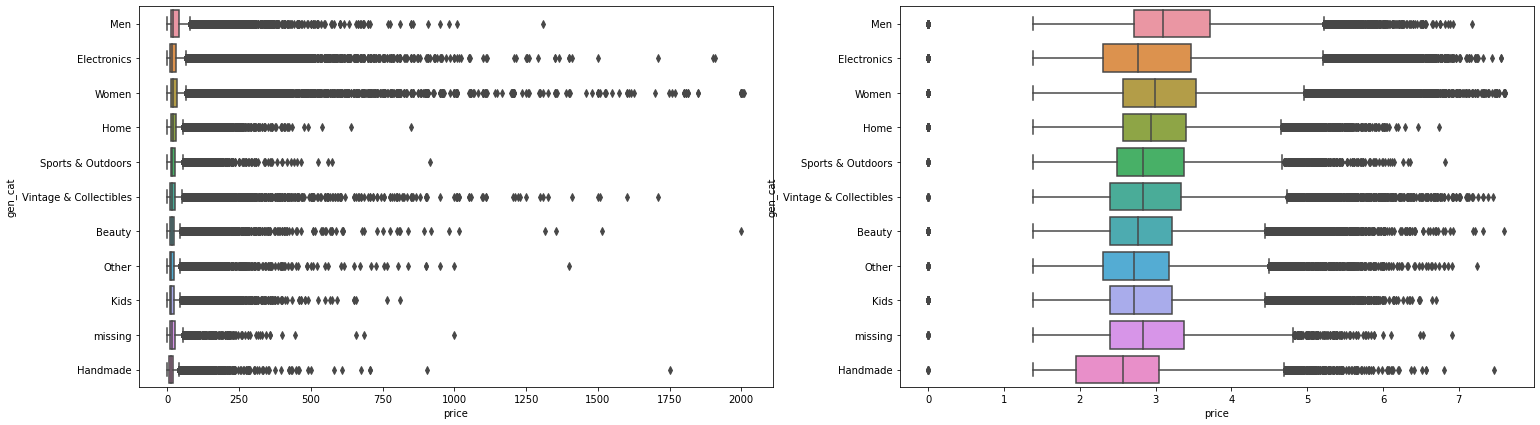

In [ ]:
# Verificação de Outliers nos preços

plt.subplots(1,2, figsize = (25,7))

plt.subplot(1,2,1)
sns.boxplot(data = train[['price', 'gen_cat']], x = 'price', y = 'gen_cat')

# Os preços possuem uma grande amplitude e dificultam a leitura em uma escala simples, a aplicação do log permite a leitura e interpretação dos valores em uma escala logaritmica.

plt.subplot(1,2,2)
sns.boxplot(data = pd.concat([train['price'].apply(lambda x: math.log(x+1)), train['gen_cat']], axis = 1), x = 'price', y = 'gen_cat')

Em ambas as visualizações notamos uma grande presença de outliers. Porém, por tratar-se de um serviço de vendas de diversos tipos de produto, espera-se que tais discrepâncias sejam naturais e por hora serão mantidas na baseline inicial.

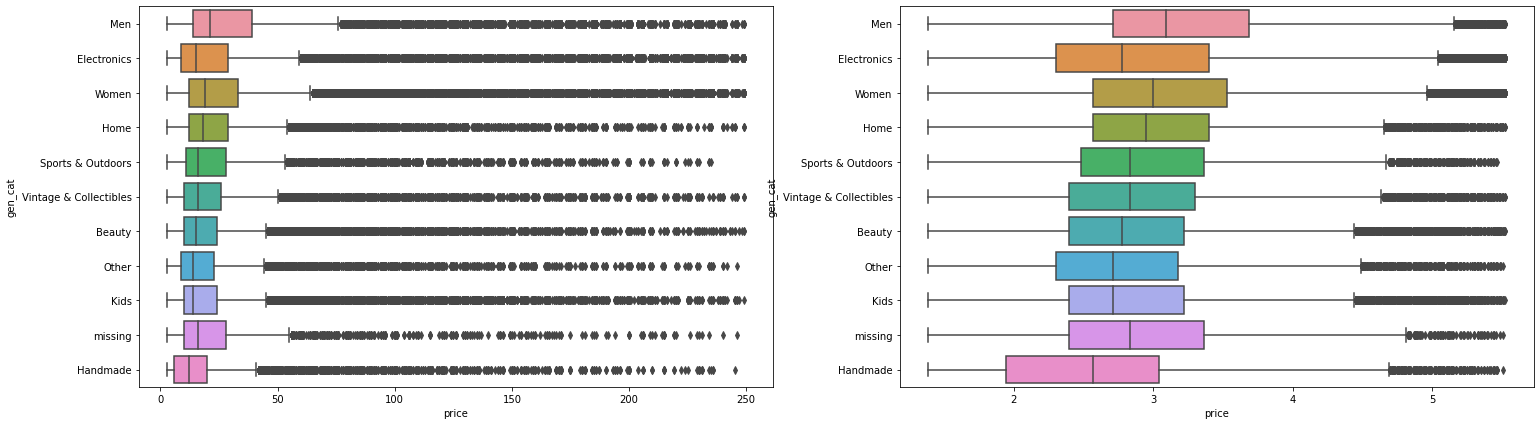

In [ ]:
plt.subplots(1,2, figsize = (25,7))

plt.subplot(1,2,1)
sns.boxplot(data = train[(train['price'] > 0) & (train['price'] < 250)][['price', 'gen_cat']], x = 'price', y = 'gen_cat')

plt.subplot(1,2,2)
sns.boxplot(data = pd.concat([train[(train['price'] > 0) & (train['price'] < 250)]['price'].apply(lambda x: math.log(x+1)), train[(train['price'] > 0) & (train['price'] < 250)]['gen_cat']], axis = 1), x = 'price', y = 'gen_cat')

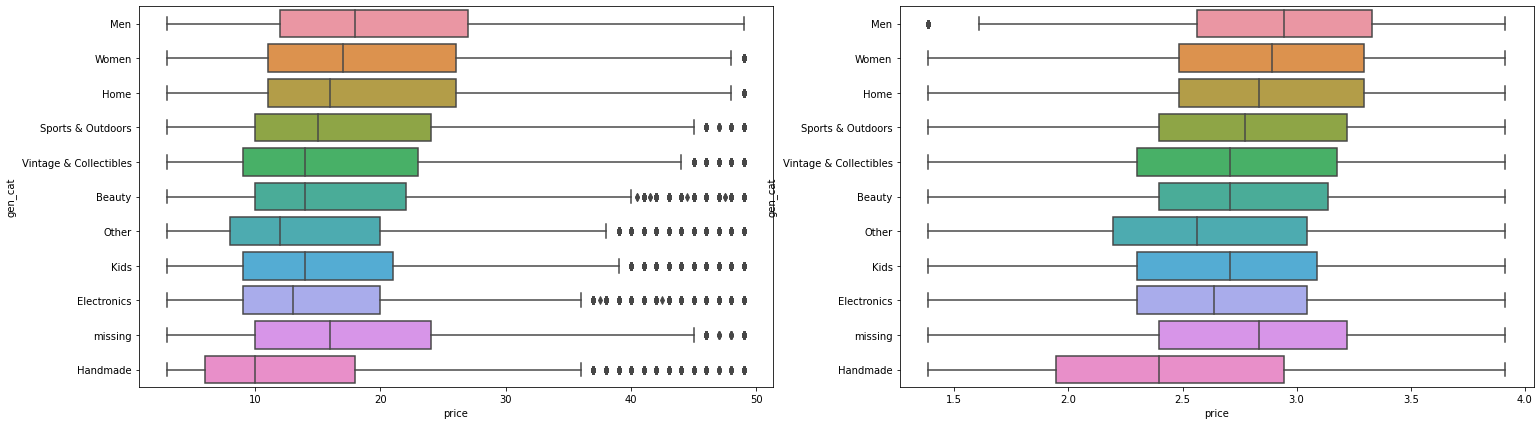

In [ ]:
plt.subplots(1,2, figsize = (25,7))

plt.subplot(1,2,1)
sns.boxplot(data = train[(train['price'] > 0) & (train['price'] < 50)][['price', 'gen_cat']], x = 'price', y = 'gen_cat')

plt.subplot(1,2,2)
sns.boxplot(data = pd.concat([train[(train['price'] > 0) & (train['price'] < 50)]['price'].apply(lambda x: math.log(x+1)), train[(train['price'] > 0) & (train['price'] < 50)]['gen_cat']], axis = 1), x = 'price', y = 'gen_cat')

Ao analisar conjuntos reduzidos de preços, notamos uma redução expressiva no número de outliers.

## Análise das categorias

In [ ]:
len(train[train['sub1_cat'] == 'Tops & Blouses']['sub2_cat'].unique())
train[train['gen_cat'] == 'Women']['sub1_cat'].unique()

array(['Tops & Blouses', 'Jewelry', 'Other', 'Swimwear', 'Dresses',
       'Shoes', 'Athletic Apparel', 'Jeans', 'Underwear',
       "Women's Handbags", 'Coats & Jackets', 'Pants', 'Sweaters',
       'Maternity', "Women's Accessories", 'Skirts', 'Suits & Blazers'],
      dtype=object)

In [ ]:
len(train[train['sub1_cat'] == 'Tops & Blouses']['sub2_cat'].unique())
train[train['sub1_cat'] == 'Tops & Blouses']['sub2_cat'].unique()

array(['Blouse', 'Tank, Cami', 'T-Shirts', 'Halter', 'Other', 'Tunic',
       'Button Down Shirt', 'Polo Shirt', 'Wrap', 'Knit Top',
       'Turtleneck'], dtype=object)

In [ ]:
len(train['category_name'].unique())

1288

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  from ipykernel import kernelapp as app


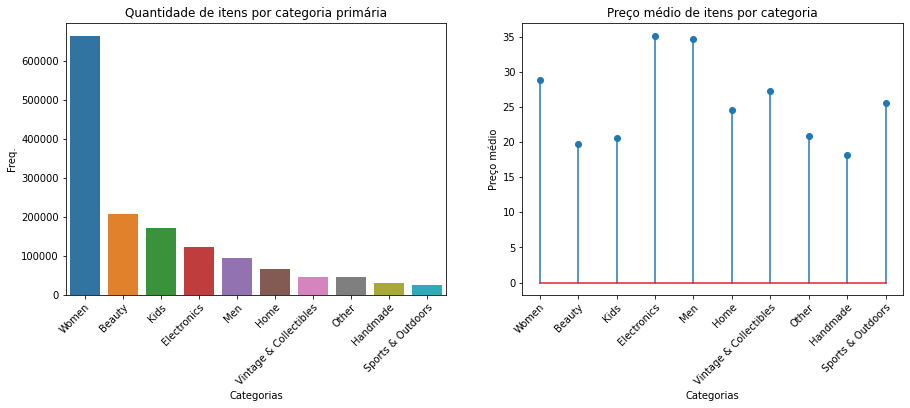

In [ ]:
x = train['gen_cat'].value_counts().reset_index()

plt.subplots(1, 2, figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(data=x[0:10], x = 'index', y = 'gen_cat')
plt.title('Quantidade de itens por categoria primária')
plt.xlabel('Categorias')
plt.ylabel('Freq.')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

x = train[['gen_cat','price']].groupby('gen_cat').agg(['count','mean']).reset_index().sort_values(by=('price','count'), ascending=False)

plt.subplot(1,2,2)
plt.stem(x['gen_cat'][0:10],x[('price','mean')][0:10])
plt.title('Preço médio de itens por categoria')
plt.xlabel('Categorias')
plt.ylabel('Preço médio')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

plt.show()

A frequência permite a retirada de alguns insights sobre o comportamento dos dados. Podemos ver que a variável ‘Women’ aparece numa frequência muito acima das demais e pode vir a gerar ruídos nos resultados do modelo de predição a ser desenvolvido. Além disso vemos que a distribuição de preços entre as categorias não apresenta uma grande variação e a maioria está presente numa mesma faixa.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  from ipykernel import kernelapp as app


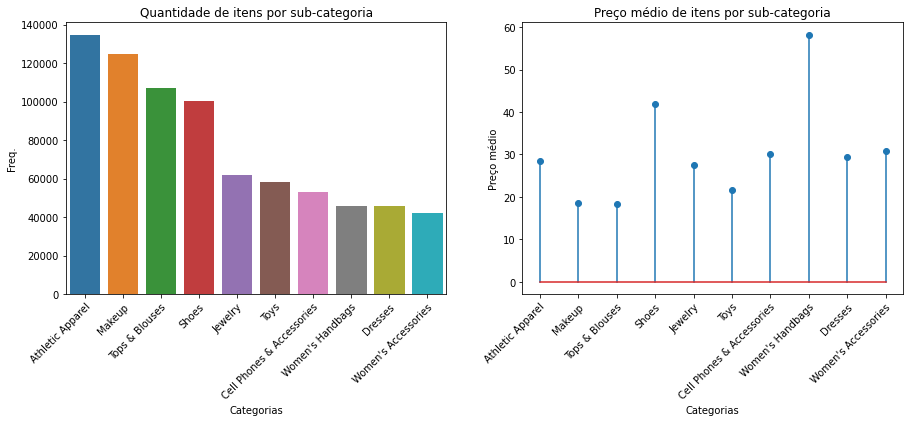

In [ ]:
x = train['sub1_cat'].value_counts().reset_index()

plt.subplots(1, 2, figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(data=x[0:10], x = 'index', y = 'sub1_cat')
plt.xlabel('Categorias')
plt.ylabel('Freq.')
plt.title('Quantidade de itens por sub-categoria')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

x = train[['sub1_cat','price']].groupby('sub1_cat').agg(['mean','count']).reset_index().sort_values(by=('price','count'), ascending=False)

plt.subplot(1,2,2)
plt.stem(x['sub1_cat'][0:10],x[('price','mean')][0:10])
plt.title('Preço médio de itens por sub-categoria')
plt.xlabel('Categorias')
plt.ylabel('Preço médio')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

plt.show()

A análise geral das sub-categorias mostra um equilíbrio muito mais saudável em relação ao equilíbrio das categorias principais, porém, seus preços mostram variações mais extremas. Isso mostra que as sub-categorias possuem uma capacidade maior de discriminação de preço do que as categorias gerais.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  from ipykernel import kernelapp as app


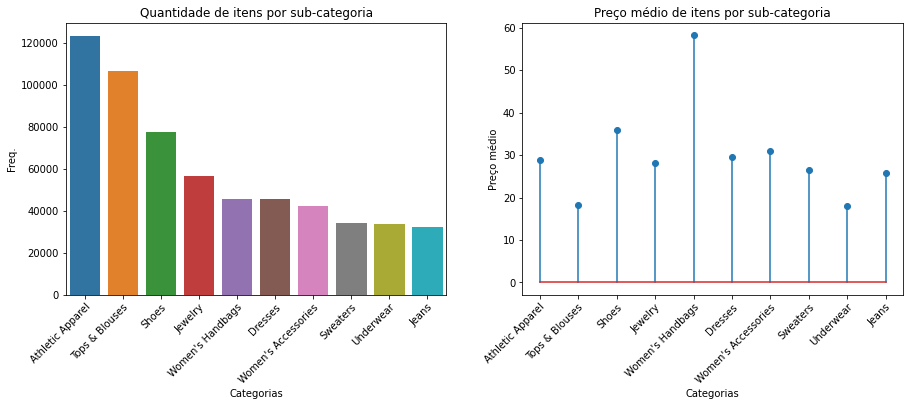

In [ ]:
x = train[train['gen_cat'] == 'Women']['sub1_cat'].value_counts().reset_index()

plt.subplots(1, 2, figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(data=x[0:10], x = 'index', y = 'sub1_cat')
plt.xlabel('Categorias')
plt.ylabel('Freq.')
plt.title('Quantidade de itens por sub-categoria')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

x = train[train['gen_cat'] == 'Women'][['sub1_cat','price']].groupby('sub1_cat').agg(['mean','count']).reset_index().sort_values(by=('price','count'), ascending=False)

plt.subplot(1,2,2)
plt.stem(x['sub1_cat'][0:10],x[('price','mean')][0:10])
plt.title('Preço médio de itens por sub-categoria')
plt.xlabel('Categorias')
plt.ylabel('Preço médio')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

plt.show()

Aprofundando-se dentro da categoria 'Women', podemos notar o perfil dentro desta categoria geral. Dentro do top 10 de itens mais vendidos dentro da categoria temos: Vestuário esportivo, tops e blusas, sapatos, joias, bolsas de mão, vestidos, acessórios, suéter, roupa íntima e jeans. Também notamos a grande amplitude, já esperada, dos preços médios dessas sub-categorias.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  from ipykernel import kernelapp as app


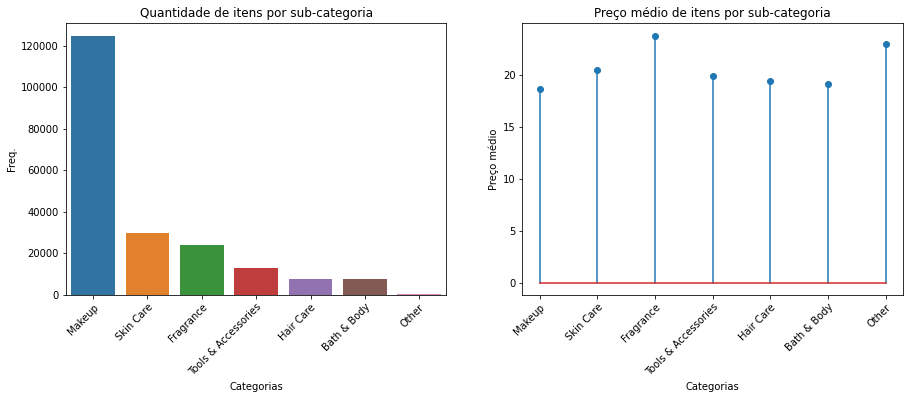

In [ ]:
x = train[train['gen_cat'] == 'Beauty']['sub1_cat'].value_counts().reset_index()

plt.subplots(1, 2, figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(data=x[0:10], x = 'index', y = 'sub1_cat')
plt.xlabel('Categorias')
plt.ylabel('Freq.')
plt.title('Quantidade de itens por sub-categoria')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

x = train[train['gen_cat'] == 'Beauty'][['sub1_cat','price']].groupby('sub1_cat').agg(['mean','count']).reset_index().sort_values(by=('price','count'), ascending=False)

plt.subplot(1,2,2)
plt.stem(x['sub1_cat'][0:10],x[('price','mean')][0:10])
plt.title('Preço médio de itens por sub-categoria')
plt.xlabel('Categorias')
plt.ylabel('Preço médio')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

plt.show()

Aprofundando-se dentro da categoria 'Beauty', a grande maioria das observações pertence a sub-categoria 'Makeup'. Dentro do top 10 de itens mais vendidos dentro da categoria temos: Maquiagem, cuidados com a pele, fragrancias, acessórios, cuidados com o cabelo, banho e corpo e outros. Dentro dessa categoria os preços são mais homogeneos, sem as grandes amplitudes vistas anteriormente.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  from ipykernel import kernelapp as app


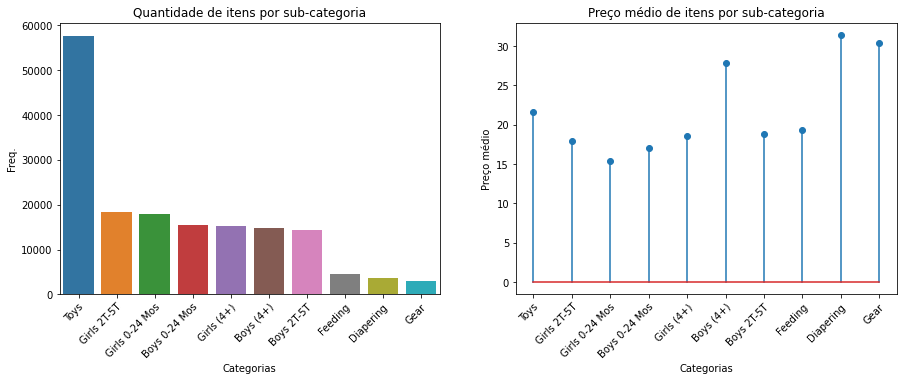

In [ ]:
x = train[train['gen_cat'] == 'Kids']['sub1_cat'].value_counts().reset_index()

plt.subplots(1, 2, figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(data=x[0:10], x = 'index', y = 'sub1_cat')
plt.xlabel('Categorias')
plt.ylabel('Freq.')
plt.title('Quantidade de itens por sub-categoria')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

x = train[train['gen_cat'] == 'Kids'][['sub1_cat','price']].groupby('sub1_cat').agg(['mean','count']).reset_index().sort_values(by=('price','count'), ascending=False)

plt.subplot(1,2,2)
plt.stem(x['sub1_cat'][0:10],x[('price','mean')][0:10])
plt.title('Preço médio de itens por sub-categoria')
plt.xlabel('Categorias')
plt.ylabel('Preço médio')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

plt.show()

Dentro da categoria 'Kids', também há grande predominancia de uma sub-categoria. Os preços dentro dessa categoria são bem distribuídos e apesar de não apresentarem grandes variações como visto anteriormente, também não são altamente uniformes.

## Análise temporal

In [ ]:
train['datetime_date'] = pd.to_datetime(train['date'], format = "%d-%m-%Y", errors = 'coerce')
train.drop('date', axis = 1, inplace=True)
train['datetime_month'] = train['datetime_date'].dt.month

In [ ]:
train[['gen_cat','price', 'datetime_month']].groupby('datetime_month').agg(['count','mean']).reset_index().sort_values(by=['datetime_month'], ascending=False)

datetime_month   price           
                    count       mean
11           12.0   67055  27.106420
10           11.0  134979  26.569626
9            10.0  134584  26.795039
8             9.0  134935  26.531641
7             8.0  134265  26.675165
6             7.0  134846  26.787973
5             6.0  134857  26.648776
4             5.0  134173  26.907828
3             4.0  135564  26.784390
2             3.0  134889  26.765437
1             2.0  127916  26.794291
0             1.0   67575  26.557558

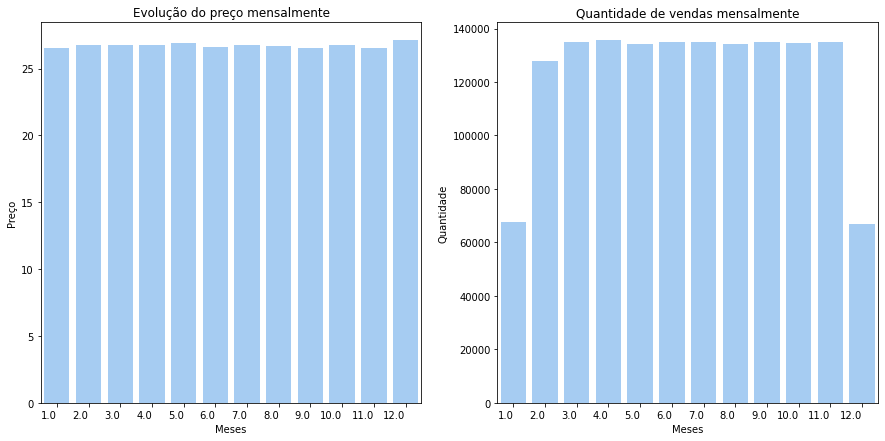

In [ ]:
x = train[['gen_cat','price', 'datetime_month']].groupby('datetime_month').agg(['count','mean']).reset_index().sort_values(by=('price','count'), ascending=False)

plt.subplots(1, 2, figsize=(15,7))
plt.subplot(1,2,1)
sns.barplot(data=x, x = 'datetime_month', y = ('price','mean'), color = '#99ccff')
plt.xlabel('Meses')
plt.ylabel('Preço')
plt.title('Evolução do preço mensalmente')
plt.xticks(rotation_mode='anchor', ha='right')

plt.subplot(1,2,2)
sns.barplot(data=x, x = 'datetime_month', y = ('price','count'), color = '#99ccff')
plt.xlabel('Meses')
plt.ylabel('Quantidade')
plt.title('Quantidade de vendas mensalmente')
plt.xticks(rotation_mode='anchor', ha='right')

plt.show()

A análise da variação do preço no tempo nos mostra um comportamento atípico dos dados. Não há grande variação na média geral dos preços no decorrer do ano e além disso há grandes quedas no primeiro mês e no último mês quando falamos sobre quantidade de vendas, porém, sem variação no preço médio.

## Análise do estoque

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if sys.path[0] == '':


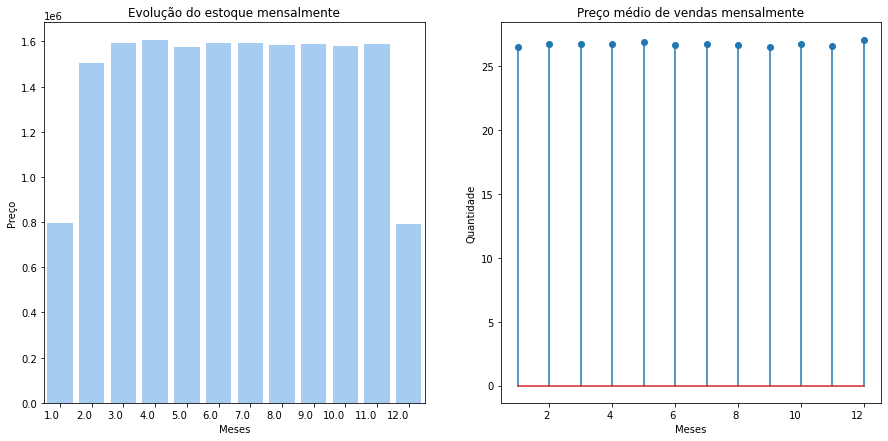

In [ ]:
x = train[['stock','price', 'datetime_month']].groupby('datetime_month').agg(['count','sum', 'mean']).reset_index().sort_values(by=('price','count'), ascending=False)

plt.subplots(1, 2, figsize=(15,7))
plt.subplot(1,2,1)
sns.barplot(data=x, x = 'datetime_month', y = ('stock','sum'), color = '#99ccff')
plt.xlabel('Meses')
plt.ylabel('Preço')
plt.title('Evolução do estoque mensalmente')
plt.xticks(rotation_mode='anchor', ha='right')

plt.subplot(1,2,2)
plt.stem(x['datetime_month'],x[('price','mean')])
plt.xlabel('Meses')
plt.ylabel('Quantidade')
plt.title('Preço médio de vendas mensalmente')
plt.xticks(rotation_mode='anchor', ha='right')

plt.show()

O estoque não apresenta grandes variações durante o ano, exceto por quedas bruscas no começo e no final do ano, que seria justificavel por um grande volume de vendas (que não ocorreu, segundo a visualização de quantidade de vendas mensalmente). Apesar dessas duas grandes variações, a média de preços permanece inalterada.

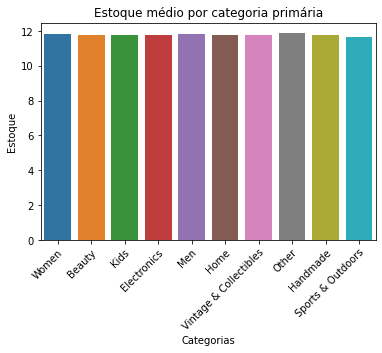

In [ ]:
x = train[['stock','price','gen_cat']].groupby('gen_cat').agg(['count','sum', 'mean']).reset_index().sort_values(by=('price','count'), ascending=False)

sns.barplot(data=x[0:10], x = 'gen_cat', y = ('stock','mean'))
plt.title('Estoque médio por categoria primária')
plt.xlabel('Categorias')
plt.ylabel('Estoque')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

plt.show()

A média de estoque de todas as categorias também tende a um mesmo valor.

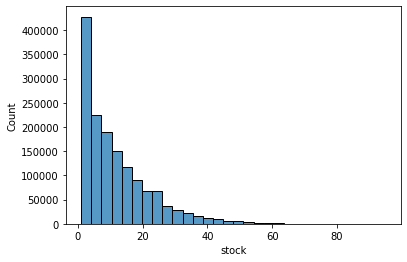

In [ ]:
sns.histplot(train['stock'], bins=30)

Segundo o histograma, temos muitos valores de 'stock' abaixo de 20 e poucos acima deste valor. Nesse sentido, podemos pensar que um produto com estoque elevado está encontrando dificuldades para ser vendido, enquanto um produto com baixo valor de estoque está em seu preço ideal ou muito barato.

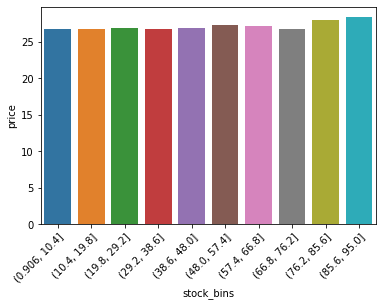

In [ ]:
x = pd.concat([train, pd.cut(train['stock'], bins=10).rename('stock_bins')], axis = 1)
x = x[['price', 'stock_bins']].groupby('stock_bins').mean().reset_index()

sns.barplot(data=x, x = 'stock_bins', y = 'price')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

plt.show()

Ao dividir os valores de estoque em diversas faixas e verificar o preço médio, também não notamos variações que justifiquem produtos com alto estoque serem mais raros que produtos com baixo estoque.

Devido ao perfil apresentado, a variável 'stock' não mostra ter um grande impacto na variação do preço. Além do estoque ser praticamente constante durante todo o ano, no momento em que essa variável cai de forma brusca, o preço médio dos produtos permanece inalterado. Sendo assim, podemos dizer que é uma variável que não adicionada nada a um modelo preditivo e sua permanência para os modelos será discutida.

## Análise da condição

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  from ipykernel import kernelapp as app


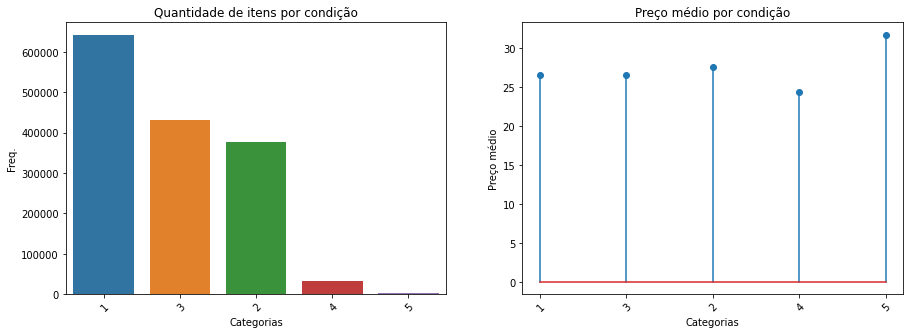

In [ ]:
x = train['item_condition_id'].value_counts().reset_index()

plt.subplots(1, 2, figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(data=x, x = 'index', y = 'item_condition_id')
plt.xlabel('Categorias')
plt.ylabel('Freq.')
plt.title('Quantidade de itens por condição')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

x = train[['item_condition_id','price']].groupby('item_condition_id').agg(['mean','count']).reset_index().sort_values(by=('price','count'), ascending=False)

plt.subplot(1,2,2)
plt.stem(x['item_condition_id'],x[('price','mean')])
plt.title('Preço médio por condição')
plt.xlabel('Categorias')
plt.ylabel('Preço médio')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

plt.show()

A distribuição de itens por condição nos mostra uma grande valorização de itens com qualidade 5 apesar da grande maioria pertencer a qualidade 1.

## Análise das marcas

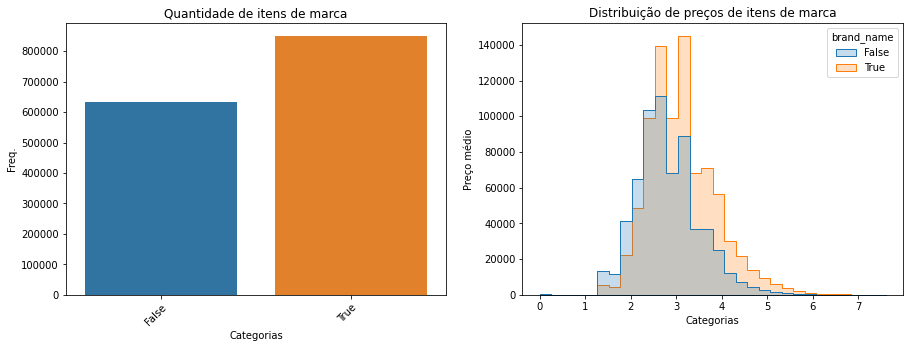

In [ ]:
x = (~train['brand_name'].isnull()).value_counts().reset_index()

plt.subplots(1, 2, figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(data=x, x = 'index', y = 'brand_name')
plt.xlabel('Categorias')
plt.ylabel('Freq.')
plt.title('Quantidade de itens de marca')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

# x = pd.concat([(~train['brand_name'].isnull()).astype('str'), train['price']], axis = 1).groupby('brand_name').agg(['mean','count']).reset_index().sort_values(by=('price','count'), ascending=False)

plt.subplot(1,2,2)
sns.histplot(data = train, x = train['price'].apply(lambda x: math.log(x+1)), bins = 30, hue = ~train['brand_name'].isnull(), element="step")
plt.title('Distribuição de preços de itens de marca')
plt.xlabel('Categorias')
plt.ylabel('Preço médio')

plt.show()

Apesar de haver marcas diferentes, a análise acima mostra que há uma variação considerável entre itens que possuem marcas. Isso nos abre uma possibilidade de no pré-processamento substituir as marcas por valores que indiquem ausência ou presença.

In [ ]:
train['brand_name'].value_counts()

PINK                    54088
Nike                    54043
Victoria's Secret       48036
LuLaRoe                 31024
Apple                   17322
                        ...  
The Learning Journey        1
Pampers Baby Fresh          1
Huggies One & Done          1
Classic Media               1
Kids Only                   1
Name: brand_name, Length: 4809, dtype: int64

## Análise pelo tipo de envio

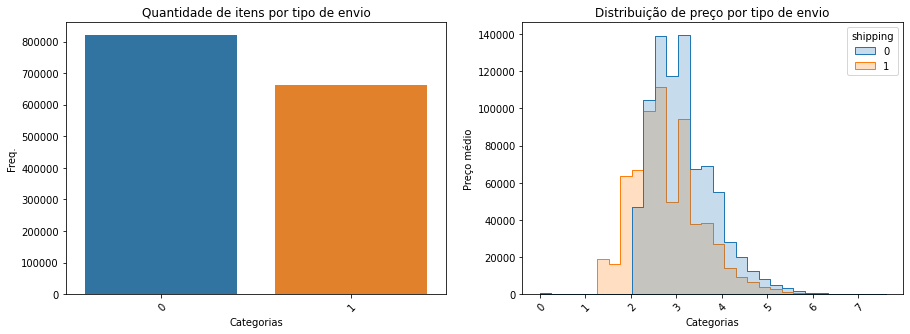

In [ ]:
x = train['shipping'].value_counts().reset_index()

plt.subplots(1, 2, figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(data=x, x = 'index', y = 'shipping')
plt.xlabel('Categorias')
plt.ylabel('Freq.')
plt.title('Quantidade de itens por tipo de envio')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

# x = train[['shipping','price']].groupby('shipping').agg(['mean','count']).reset_index().sort_values(by=('price','count'), ascending=False)

plt.subplot(1,2,2)
sns.histplot(x = train['price'].apply(lambda x: math.log(x+1)), bins = 30, hue = train['shipping'], element="step")
plt.title('Distribuição de preço por tipo de envio')
plt.xlabel('Categorias')
plt.ylabel('Preço médio')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

plt.show()

Além disso, o modo de cobrança do frete também influencia no preço final do produto. E, ao contrário do que se espera, o preço tende a subir quando o frete é pago pelo vendedor. Isso provavelmente acontece porque geralmente o vendedor paga o frete para vendas mais caras como forma de impulsionamento.

## Outras análises

Estas estatísticas indicam a dimensão do problema que será enfrentado durante a modelagem.

In [ ]:
train

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,stock,gen_cat,sub1_cat,sub2_cat,datetime_date,datetime_month
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,27,Men,Tops,T-shirts,2018-06-18,6.0
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,15,Electronics,Computers & Tablets,Components & Parts,2018-03-18,3.0
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,14,Women,Tops & Blouses,Blouse,2018-10-25,10.0
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,1,Home,Home Décor,Home Décor Accents,2018-03-20,3.0
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,13,Women,Jewelry,Necklaces,2018-05-16,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl...",2,Women,Dresses,Mid-Calf,2018-10-13,10.0
1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t,10,Kids,Girls 2T-5T,Dresses,2018-10-06,10.0
1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NaN,12.0,0,"Used once or twice, still in great shape.",15,Sports & Outdoors,Exercise,Fitness accessories,2018-08-06,8.0
1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NaN,45.0,1,There is 2 of each one that you see! So 2 red ...,20,Home,Home Décor,Home Décor Accents,2018-02-13,2.0


Verificando a qualidade da maior parte dos produtos oferecidos pelo mercari.

In [ ]:
train['item_condition_id'].value_counts()

1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64

Quais features tem correlação com o preço.

In [ ]:
train.corr()["price"].sort_values(ascending=False)

price             1.000000
stock             0.001404
datetime_month   -0.000223
shipping         -0.097211
Name: price, dtype: float64

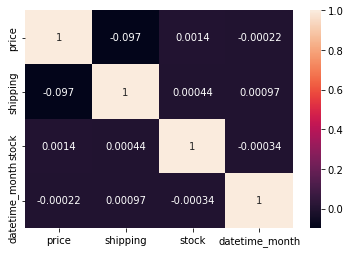

In [ ]:
sns.heatmap(train.corr(), annot=True)

A partir das correlações acima, observa-se que o frete é inversamente proporcionais ao preço.

Copiando o dataset para verificar os valores nulos.

In [ ]:
# Faça uma cópia de trabalho dos dados 
df = train.copy() 
df.isna().sum().loc[df.isna().sum()>0].sort_values()

item_description         4
category_name         6327
datetime_date         6897
datetime_month        6897
brand_name          632682
dtype: int64

In [ ]:
train.shape

(1482535, 13)

* 43% dos registros não tem nomes de marca
* 0,4% dos registros não tem categorias
* 0,0003% não possuí descrição do item

Será excluído os valores nulos, pois as linhas nulas, são insignificantes a quantidade de linhas existentes.

Deixamos as marcas, pois acreditamos que os valores nulos, são importantes para a precificação. Provavelmente usaremos em dummies no modelo, entre com e sem marca e não por marca individualmente.

Filtrando uma marca ‘Apple’ e avaliando os produtos apresentados, entre aparelhos celulares, capinhas, tablets.

In [ ]:
apple = train[train['brand_name'] == 'Apple']


In [ ]:
apple

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,stock,gen_cat,sub1_cat,sub2_cat,datetime_date,datetime_month
26,Otterbox Defender iPhone 6 Plus/6s Plus,1,"Electronics/Cell Phones & Accessories/Cases, C...",Apple,13.0,1,Brand new Otterbox Defender iPhone 6 Plus/6s Plus,2,Electronics,Cell Phones & Accessories,"Cases, Covers & Skins",2018-02-18,2.0
149,LIKE NEW IPHONE 5C,2,Electronics/Cell Phones & Accessories/Cell Pho...,Apple,104.0,0,Just Upgraded So Now Finally Getting Rid Of My...,23,Electronics,Cell Phones & Accessories,Cell Phones & Smartphones,NaT,NaN
300,Jordan iPhone case only for plus,1,"Electronics/Cell Phones & Accessories/Cases, C...",Apple,5.0,1,JORDAN IPHONE CASE ONLY FOR IPHONE 6 plus iPho...,16,Electronics,Cell Phones & Accessories,"Cases, Covers & Skins",2018-12-15,12.0
582,iPhone 6/6s plus cases,3,"Electronics/Cell Phones & Accessories/Cases, C...",Apple,20.0,1,4 iPhone 6/6s plus cases.,7,Electronics,Cell Phones & Accessories,"Cases, Covers & Skins",2018-06-26,6.0
757,iPod nano 7th generation,3,"Electronics/TV, Audio & Surveillance/Portable ...",Apple,62.0,1,In perfect working condition. One light scratc...,3,Electronics,"TV, Audio & Surveillance",Portable Audio & Accessories,2018-04-15,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482223,LuMee Duo iPhone 6 Plus 6s Plus 7 Plus,1,"Electronics/Cell Phones & Accessories/Cases, C...",Apple,24.0,1,Black Marble Free Shipping,18,Electronics,Cell Phones & Accessories,"Cases, Covers & Skins",2018-02-09,2.0
1482230,iPhone 7 case,1,"Electronics/Cell Phones & Accessories/Cases, C...",Apple,10.0,1,Brand new iPhone 7 glitter case. Protects phon...,5,Electronics,Cell Phones & Accessories,"Cases, Covers & Skins",2018-09-14,9.0
1482291,iPhone 7 Plus Case,1,"Electronics/Cell Phones & Accessories/Cases, C...",Apple,7.0,1,Flexible slim glitter bling case new,25,Electronics,Cell Phones & Accessories,"Cases, Covers & Skins",2018-07-13,7.0
1482387,IPAD PRO 8.7 INCH 32GB,1,Electronics/Computers & Tablets/iPad/Tablet/eB...,Apple,509.0,0,"BRAND NEW IN BOX NEVER OPEN ,IPAD PRO 32GB,8.9...",1,Electronics,Computers & Tablets,iPad,2018-11-15,11.0


Analisando sobre a sub-categoria2 ‘Cell Phones & Smartphones’, verificamos vários aparelhos, de modelos distintos, preços variados, pois alguns modelos são obsoletos.

In [ ]:
Cell = apple[apple['sub2_cat'] == 'Cell Phones & Smartphones']

In [ ]:
Cell

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,stock,gen_cat,sub1_cat,sub2_cat,datetime_date,datetime_month
149,LIKE NEW IPHONE 5C,2,Electronics/Cell Phones & Accessories/Cell Pho...,Apple,104.0,0,Just Upgraded So Now Finally Getting Rid Of My...,23,Electronics,Cell Phones & Accessories,Cell Phones & Smartphones,NaT,NaN
796,iPhone 4,3,Electronics/Cell Phones & Accessories/Cell Pho...,Apple,30.0,1,Black iPhone 4 for Verizon comes with charger,1,Electronics,Cell Phones & Accessories,Cell Phones & Smartphones,2018-06-12,6.0
1330,iPhone 6 64gb Gold (Sprint),3,Electronics/Cell Phones & Accessories/Cell Pho...,Apple,305.0,1,Fully functional iPhone 6 64gb Rose Gold. Only...,20,Electronics,Cell Phones & Accessories,Cell Phones & Smartphones,2018-07-02,7.0
1536,iPhone 6 Plus,2,Electronics/Cell Phones & Accessories/Cell Pho...,Apple,310.0,1,iPhone 6 Plus US Cellular. Clean ESN. Excellen...,44,Electronics,Cell Phones & Accessories,Cell Phones & Smartphones,2018-02-06,2.0
1593,iPhone 5c,3,Electronics/Cell Phones & Accessories/Cell Pho...,Apple,34.0,0,Blue iPhone 5c Screen Was Recently Replaced An...,9,Electronics,Cell Phones & Accessories,Cell Phones & Smartphones,2018-04-15,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481376,iPod 5th generation,2,Electronics/Cell Phones & Accessories/Cell Pho...,Apple,15.0,1,This iPod 5th generation is iCloud locked and ...,34,Electronics,Cell Phones & Accessories,Cell Phones & Smartphones,2018-12-08,12.0
1481408,IPhone 5s 32gb unlocked,3,Electronics/Cell Phones & Accessories/Cell Pho...,Apple,167.0,1,For sale is an Apple iphone 5S 32GB unlocked. ...,11,Electronics,Cell Phones & Accessories,Cell Phones & Smartphones,2018-04-20,4.0
1481709,iPhone 5s Verizon unlocked,5,Electronics/Cell Phones & Accessories/Cell Pho...,Apple,49.0,0,This phone is iCloud unlocked. It will also ne...,10,Electronics,Cell Phones & Accessories,Cell Phones & Smartphones,2018-02-03,2.0
1481811,IPhone 6,5,Electronics/Cell Phones & Accessories/Cell Pho...,Apple,40.0,0,Activation lock cracked comes with case no cha...,11,Electronics,Cell Phones & Accessories,Cell Phones & Smartphones,2018-04-14,4.0
